In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
file_path = "cleaned_coin_Bitcoin.csv" 
df = pd.read_csv(file_path)

In [3]:
df['Daily Return'] = df['Close'].pct_change() * 100

# Create a new column for Market Trend (Up, Down, Neutral)
df['Market Trend'] = df['Daily Return'].apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'Neutral'))


In [4]:
# Encode the Market Trend labels as integers (Up = 0, Down = 1, Neutral = 2)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Market Trend'] = le.fit_transform(df['Market Trend'])

# Drop rows with missing values after creating 'Daily Return'
df = df.dropna()

In [5]:
df.head()


,Date,High,Low,Open,Close,Volume,Marketcap,Daily Return,50-Day MA,200-Day MA,Price Diff,Volatility,Open-Close Diff,High-Low Range,Market Trend
1,2013-11-15 23:59:59,437.890015,396.109985,419.410004,0.003788,0.0,5.013561e+09,-0.929379,0.000102,0.000031,0.003168,0.382007,419.406216,41.780029,0
2,2013-11-16 23:59:59,450.260010,415.570007,417.279999,0.004139,0.0,5.282849e+09,9.285081,0.000209,0.000065,0.002617,0.382844,417.275860,34.690002,2
3,2013-11-17 23:59:59,500.579987,440.239990,440.959991,0.004959,0.0,5.907842e+09,19.796497,0.000335,0.000108,0.004611,0.395968,440.955033,60.339996,2
4,2013-11-18 23:59:59,703.780029,494.940002,496.579987,0.008298,0.0,8.449070e+09,67.339269,0.000534,0.000176,0.016155,0.606395,496.571689,208.840027,2
5,2013-11-19 23:59:59,806.109985,456.390015,712.760010,0.006419,0.0,7.022949e+09,-22.637440,0.000692,0.000231,0.027107,0.646978,712.753590,349.719971,0


In [6]:
# Define features (X) and target (y) for Market Trend prediction
X_trend = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap', '50-Day MA', '200-Day MA', 'Price Diff', 'Volatility', 'Daily Return', 'Open-Close Diff', 'High-Low Range']]
y_trend = df['Market Trend']  # Target variable is Market Trend (Up, Down, Neutral)


In [7]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_trend, X_test_trend, y_train_trend, y_test_trend = train_test_split(X_trend, y_trend, test_size=0.2, shuffle=False)

# Check for NaN values
print("Check for NaN values in X_train_trend:", X_train_trend.isnull().sum())

# Check for infinite values
import numpy as np
print("Check for infinity values in X_train_trend:", np.isinf(X_train_trend).sum())


Check for NaN values in X_train_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64
Check for infinity values in X_train_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       1
Open-Close Diff    0
High-Low Range     0
dtype: int64


In [8]:
# Replace NaN values with the mean of the column
X_train_trend = X_train_trend.apply(lambda x: x.fillna(x.mean()), axis=0)
X_test_trend = X_test_trend.apply(lambda x: x.fillna(x.mean()), axis=0)


# Replace infinity values with a large finite number
X_train_trend = X_train_trend.replace([np.inf, -np.inf], 0)
X_test_trend = X_test_trend.replace([np.inf, -np.inf], 0)

In [9]:
# You can similarly check for NaN and infinite values in the test set
print("Check for NaN values in X_test_trend:", X_test_trend.isnull().sum())
print("Check for infinity values in X_test_trend:", np.isinf(X_test_trend).sum())

Check for NaN values in X_test_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64
Check for infinity values in X_test_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64


In [10]:
# Handle missing values by filling them with the mean or using forward/backward filling
X_train_trend.fillna(X_train_trend.mean(), inplace=True)
X_test_trend.fillna(X_test_trend.mean(), inplace=True)


In [11]:
# Replace infinite values with NaN, then fill them with the mean or drop them
X_train_trend.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_trend.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values (if any) with the mean
X_train_trend.fillna(X_train_trend.mean(), inplace=True)
X_test_trend.fillna(X_test_trend.mean(), inplace=True)


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the feature data using MinMaxScaler
scaler_trend = MinMaxScaler(feature_range=(0, 1))
X_train_trend_scaled = scaler_trend.fit_transform(X_train_trend)
X_test_trend_scaled = scaler_trend.transform(X_test_trend)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'Market Trend' target variable
encoder_trend = LabelEncoder()
y_train_trend_encoded = encoder_trend.fit_transform(y_train_trend)
y_test_trend_encoded = encoder_trend.transform(y_test_trend)


In [18]:
import numpy as np
import pandas as pd

# Check for NaN and Infinite values in the data
print("Check for NaN values in X_train_trend:", np.isnan(X_train_trend).sum())
print("Check for Inf values in X_train_trend:", np.isinf(X_train_trend).sum())


X_train_trend['Daily Return'].replace([np.inf, -np.inf], X_train_trend['Daily Return'].mean(), inplace=True)
X_test_trend['Daily Return'].replace([np.inf, -np.inf], X_test_trend['Daily Return'].mean(), inplace=True)

# Check for NaN and Infinite values in the data
print("Check for NaN values in X_train_trend:", np.isnan(X_train_trend).sum())
print("Check for Inf values in X_train_trend:", np.isinf(X_train_trend).sum())

Check for NaN values in X_train_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64
Check for Inf values in X_train_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64
Check for NaN values in X_train_trend: Open               0
High               0
Low                0
Close              0
Volume             0
Marketcap          0
50-Day MA          0
200-Day MA         0
Price Diff         0
Volatility         0
Daily Return       0
Open-Close Diff    0
High-Low Range     0
dtype: int64
Check for Inf values in X

C:\Users\Aleix\AppData\Local\Temp\ipykernel_21304\3075000147.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_trend['Daily Return'].replace([np.inf, -np.inf], X_train_trend['Daily Return'].mean(), inplace=True)
C:\Users\Aleix\AppData\Local\Temp\ipykernel_21304\3075000147.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,           # Increase max depth to control overfitting
    min_child_weight=3,    # A higher value to control overfitting
    learning_rate=0.05,    # Smaller learning rate for better generalization
    subsample=0.8,         # Subsampling to add randomness
    colsample_bytree=0.8,  # Randomly select features to build trees
    random_state=42
)


# Train the model
xgb_model.fit(X_train_trend, y_train_trend)

# Predict using the trained model
y_pred_trend_xgb = xgb_model.predict(X_test_trend)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_trend, y_pred_trend_xgb))
print("Classification Report:\n", classification_report(y_test_trend, y_pred_trend_xgb))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           2       1.00      1.00      1.00       304

    accuracy                           1.00       559
   macro avg       1.00      1.00      1.00       559
weighted avg       1.00      1.00      1.00       559



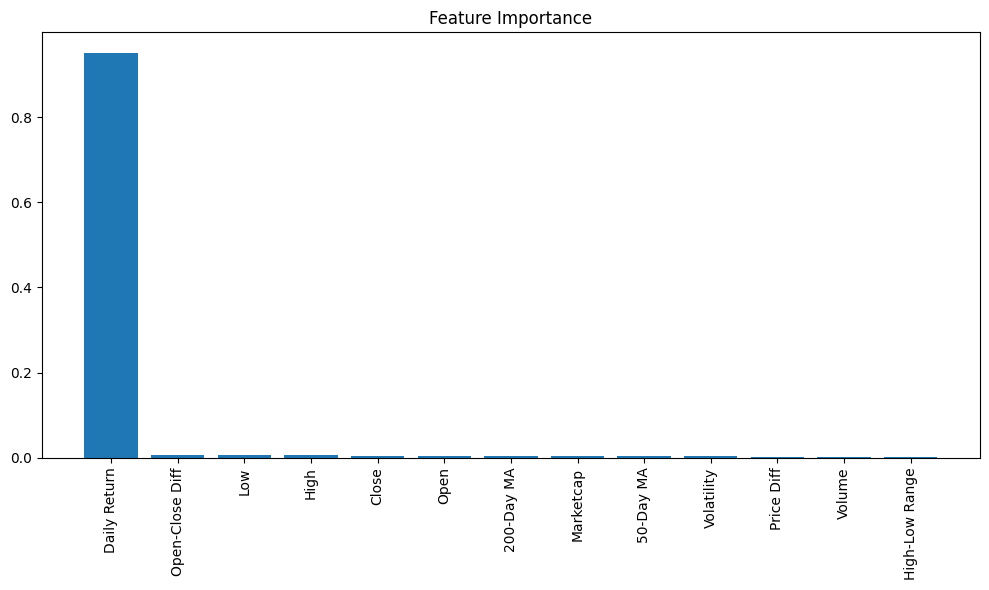

In [23]:
# Check feature importance
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_trend.shape[1]), importances[indices], align="center")
plt.xticks(range(X_trend.shape[1]), X_trend.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train_trend, y_train_trend, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy: {scores.mean()} ± {scores.std()}")


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'